## 2024 데이터 통신 설계 기말 프로젝트
### 1번 프로젝트
`tr_qpsk.csv`를 이용하여 딥러닝 기반의 QPSK 복조 (Decoder)를 학습한다.

이후 `te_qpsk.csv` 파일을 이용하여 정확도가 80% 이상인 모델을 사용하고자 한다.

이때 Ground Truth는 `*_dec.csv` 파일을 사용하여 지도학습을 수행한다.

학습이 완료된 모델(디코더)를 사용하여 AWGN 함수를 거친 입력 값을 비트스트림으로 변환한다.

변환한 비트스트림과 `te_bit.csv` 파일(테스트 셋)을 비교하여 에러를 계산한다 **(BER 계산)**

**(BER 계산)** 으로 그래프를 그린다.


![project1](./assets/project1.png)

### 라이브러리 Import
- torch : 인공지능 모델 생성, 학습용
- pandas : csv파일 로드 및 데이터 프레임 생성 용
- numpy : array 데이터 타입 처리용
- sklearn : 학습된 모델 정확도 판단용
- matplotlib : 그래프 생성 및 시각화 용

GPU 사용 가능 판단 여부 Print 초기 확인

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
print(torch.cuda.is_available())

True


### 지원 사항 : AWGN 함수
`기말 프로젝트.pdf` 파일 내에서 지원하는 함수의 경우 문법 에러 및 실제 구동 시에 에러가 발생하여 하단 함수로 수정함

**[제공함수]**
```python
def awgn_(input, dB_snr):
    snr = 10**(dB_snr / 10)
    signal_powerpower = 1
    awgn_power = signal_power / snr
    awgn = torch.sqrt(awgn_power / 2) * (
        torch.rand_like(input, dtype=torch.float32) + 1j * torch.rand_like(symbols, dtype=torch.float32)
    )
    return input + awgn
```
**[변경함수]**
```python
def awgn_(input, dB_snr):
    snr = 10**(dB_snr/10)
    # 변수 이름 수정
    signal_power = 1
    awgn_power = signal_power / snr
    # 텐서 계산을 위해 텐서 타입으로 변환
    awgn_power_tensor = torch.tensor(awgn_power, dtype=torch.float32)
    # symbols 변수 선언 및 파라미터에 참조 할 수 없어 input 변수를 사용하여 input 차원에 맞는 렌덤 값 생성
    awgn = torch.sqrt(awgn_power_tensor / 2)*(
        torch.randn_like(input, dtype=torch.float32)+1j*torch.randn_like(input, dtype=torch.float32)
    )
    return input + awgn
```

In [18]:
# [변경 함수]
def awgn_(input, dB_snr):
    snr = 10**(dB_snr/10)
    signal_power = 1
    awgn_power = signal_power / snr
    # 텐서 계산을 위해 텐서 타입으로 변환
    awgn_power_tensor = torch.tensor(awgn_power, dtype=torch.float32)
    awgn = torch.sqrt(awgn_power_tensor / 2)*(
        torch.randn_like(input, dtype=torch.float32)+1j*torch.randn_like(input, dtype=torch.float32)
    )
    return input + awgn

### 딥러닝 기반 QPSK 디코더 모델 구현
딥러닝 기반의 QPSK 디코더의 경우, 기본적으로 입력 데이터는 실수와 허수가 동시에 존재하는 데이터가 들어가서
결과 값으로는 비트 스트림을 출력해야한다.

1. DNN 기반의 QPSK 디코더
2. CNN 기반의 QPSK 디코더
두 종류의 딥러닝 QPSK 디코더를 구현하여, 성능이 더 좋은 모델을 사용한다.

#### DNN 기반 모델 구현
1. 모델 구조 설명
- 입력 레이어 : 입력 데이터는 2차원으로 구성됩니다. (실수, 허수)
- Fully Connected Layer : 2차원으로 입력 받은 데이터를 8개의 노드로 확장하고 이후 은닉층을 하나 더 쌓아 12개의 노드로 확장합니다.
    > - 은닉층에서는 2차원으로 입력 받은 데이터에 대해 패턴을 학습하게 됩니다.
    > - 또한 활성 함수 (Activation Function)의 경우 `Relu`를 사용하여 기울기 소실을 방지하였습니다.
- 결과 레이어 : 최종적으로는 QPSK 디코더 이기 때문에 `00(0), 01(1), 10(2), 11(3)`4개의 종류를 분류해야 합니다.
    > - 따라서 결과 레이어에서는 `Softmax`를 이용하여 다중 클래스 분류를 수행해야합니다.
- 모델 구조의 그림은 아래와 같습니다.

![alt text](./assets/dnn.png)

2. 한계점
- 데이터 신호의 경우 시계열 데이터로 시계열 특성을 잘 이용해야하는데, DNN의 경우 이런 시계열 특성을 잘 살리지 못하기 때문에 다른 모델을 사용해보는 것도 좋은 것 같다고 생각합니다.
- 시계열 데이터를 잘 다룰 수 있는 모델로 `RNN`, `LSTM`등 의 모델 구조를 사용하고 싶었으나, 수업 시간에 배우지 않아 해당 모델을 사용하지 않았습니다.


In [19]:
# QPSK Decoder Model (DNN)
class QPSKDemodulationDNN(nn.Module):
    def __init__(self):
        super(QPSKDemodulationDNN, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 4)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

#### CNN 기반 모델 구현
1. 모델 구조 설명
- 입력 레이어 : 
    - 입력 데이터는 QPSK 신호의 I/Q 성분으로 (batch_size, 2)의 형태입니다.
    - CNN은 채널 개념을 필요로 하기 때문에 `unsqueeze(1)`를 사용해 채널 차원을 추가하여 (batch_size, 1, 2) 형태로 변경합니다.
- Convolutional Layer : 
    - **stride=1**과 **padding=1**으로 입력과 출력의 크기를 동일하게 유지합니다.
    - **Kernel Size**의 경우 홀수로 많이 설정하기 때문에 3으로 설정합니다.
- Flatten
    - Conv1d 레이어의 출력 데이터를 `Flatten`하여 Fully Connected 레이어에 전달합니다.
- 결과 레이어 : 최종적으로는 QPSK 디코더 이기 때문에 `00(0), 01(1), 10(2), 11(3)`4개의 종류를 분류해야 합니다.
    - 따라서 결과 레이어에서는 `Softmax`를 이용하여 다중 클래스 분류를 수행해야합니다.
- 모델 구조의 그림은 아래와 같습니다.

2. 장점
- DNN과 달리 CNN은 데이터의 세세한 패턴을 학습하는 데 유리합니다.

In [20]:
# QPSK Decoder Model (CNN)
class QPSKDemodulationCNN(nn.Module):
    def __init__(self):
        super(QPSKDemodulationCNN, self).__init__()
        
        # 1D Convolutional Layer (입력 채널을 1로 설정하고 8개의 출력 채널을 생성)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8 * 2, 4)  # Flatten 이후 4개 클래스로 출력
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.softmax(self.fc1(x))
        return x

### 지원 사항 : 데이터 셋
- tr_dec.csv : 500000X1의 훈련용 자연수스트림(0~3)
- tr_bits.csv : 500000X2의 훈련용비트스트림
- tr_qpsk.csv :  500000X1의 훈련용 QPSK변조심볼열
- te_dec.csv : 100000X1의 시험용 자연수스트림(0~3)
- te_bits.csv : 100000X2의 시험용 비트스트림
- te_qpsk.csv : 100000X1의 시험용 QPSK변조심볼열

#### 데이터 셋 전처리 (Preprocessing)
1. `pytorch`는 복소수 연산이 어렵기 때문에 Input Layer에 실수와 허수를 분리하는 전처리 과정이 필요하다.
    - 실수와 허수를 분리 후, 데이터 관리를 위해 데이터 프레임에 각 `Real`과 `Imainary` 컬럼으로 각 데이터를 분리하여 저장하였다.
2. 모델 학습의 정답 값으로 10진수 데이터를 사용하였다. (0~3)의 정수형 데이터
    - 정답 값의 Class가 2개 이상이므로 `Softmax`를 사용해야 하며, 이 과정에서 `One-hot Encoding` 과정이 필요하지만, 손실 함수를 `Cross Entropy Loss`를 사용할 예정이기에 `One-hot Encoding`은 따로 진행하지 않았다. (`Cross Entropy Loss`에서 자동으로 One-hot Encoding을 진행하기 때문)
3. 데이터 학습 시, 미니 배치 사용
    - 미니 배치 사용을 위해 Training Data Set과 Test Data Set의 DataLoader를 정의하였다.

In [21]:
# Training Set 준비
train_df = pd.read_csv('./data/tr_qpsk.csv', header=None)
# 복소수 형태로 변환
train_df[0] = train_df[0].str.replace('i', 'j')  # 'i'를 'j'로 변경 (Python 복소수 표기법에 맞춤)
train_complex_numbers = train_df[0].apply(lambda x: complex(x))

# 실수부와 허수부 분리
train_qpsk_real_parts = train_complex_numbers.apply(lambda x: x.real)
train_qpsk_imag_parts = train_complex_numbers.apply(lambda x: x.imag)

# Ground Truth (dec)
train_dec = np.loadtxt('./data/tr_dec.csv', delimiter=',')
# DataFrame 생성
train_df = pd.DataFrame({'Real': train_qpsk_real_parts, 
                         'Imaginary': train_qpsk_imag_parts, 
                         'dec': train_dec})
# PyTorch 텐서로 변환
train_x_tensor = torch.Tensor(train_df[['Real', 'Imaginary']].values)
train_y_tensor = torch.LongTensor(train_df['dec'].values)

# 미니 배치 학습을 위해 DataLoader 생성
train_data = TensorDataset(train_x_tensor, train_y_tensor)
BATCH_SIZE = 1000
train_loader = DataLoader(dataset=train_data, 
                    batch_size=BATCH_SIZE, shuffle=True)

# Test Set 준비
test_df = pd.read_csv('./data/te_qpsk.csv', header=None)
test_df[0] = test_df[0].str.replace('i', 'j')
test_complex_numbers = test_df[0].apply(lambda x: complex(x))

test_qpsk_real_parts = test_complex_numbers.apply(lambda x: x.real)
test_qpsk_imag_parts = test_complex_numbers.apply(lambda x: x.imag)
test_dec = np.loadtxt('./data/te_dec.csv', delimiter=',')

test_df = pd.DataFrame({'Real': test_qpsk_real_parts, 
                        'Imaginary': test_qpsk_imag_parts, 
                        'dec': test_dec})

# PyTorch 텐서로 변환
test_x_tensor = torch.Tensor(test_df[['Real', 'Imaginary']].values)
test_y_tensor = torch.LongTensor(test_df['dec'].values)

# 미니 배치 학습을 위해 DataLoader 생성
test_data = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(dataset=test_data, 
                    batch_size=len(test_data), shuffle=False)


### DNN 모델 학습
- GPU를 이용한 가속
    > - GPU를 사용하기 위해 사용 여부 확인 후 사용.

- loss Function (손실함수) : Cross Entropy Loss 사용
    > - 소프트맥스 분류기를 사용하기 때문에 Cross Entropy Loss 손실함수를 사용하여 손쉽게 분류가 가능하다.

- Optimizer : Adam 사용
    > - Adam이 현재 성능이 가장 좋은 Optimizer이기에 사용.

- 미니 배치 학습
     - 미니 배치 학습을 위해 `DataLoader`에서 Batch Size를 1000으로 설정함.
     - Batch Size가 너무 작으면 전체 데이터를 대표하지 못하기 때문에 적절한 Size 설정이 필요하다.
     - 이러한 점으로 고려해봤을 때 데이터의 Input 주기를 고려해서 설정하는 것이 중요해 보인다. (1초에 N개의 데이터 쌍이 들어왔는가?)

- Epoch : 10
    > - 학습을 시키는 도중 Epoch가 2~3회 정도 마쳤을 때 이미 Accuarcy가 1.0에 도달하였기 때문에 더 이상 Epoch 수를 증가 시키는 것은 무의미하다고 판단함.
    > - Epoch가 적게 동작했음에도 불구하고 Accuarch가 1.0에 도달했다는 것은 Overfitting이 발생하였다는 것으로 보임.
    

In [22]:
# GPU 사용 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 모델 초기화
model = QPSKDemodulationDNN().to(device)
# model = QPSKDemodulationCNN()
cel = torch.nn.CrossEntropyLoss()  # 손실 함수
# Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 10
loss_lst = []  # 손실 저장
acc_lst = []  # 정확도 저장

for epoch in range(epochs):
    model.train()
    l_sum = 0
    for batch_idx, (x,y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        optimizer.zero_grad()
        loss = cel(y_pred, y)
        loss.backward()
        optimizer.step()
        l_sum += loss.item()
    loss = l_sum/len(train_loader)
    loss_lst.append(loss)
    model.eval()
    correct = 0
    for batch_idx, (x,y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        predicted = torch.argmax(y_pred, dim=1)
        correct += torch.sum(predicted == y)
    accuracy = correct / len(test_data)
    # 정확도를 CPU로 이동하여 저장 -> 그래프 그릴 때 에러 방지
    acc_lst.append(accuracy.cpu().numpy())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


c:\Users\Kyounghwan-Kim\anaconda3\envs\space-search\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10, Loss: 1.1082, Accuracy: 1.0000
Epoch 2/10, Loss: 0.7832, Accuracy: 1.0000
Epoch 3/10, Loss: 0.7534, Accuracy: 1.0000
Epoch 4/10, Loss: 0.7479, Accuracy: 1.0000
Epoch 5/10, Loss: 0.7459, Accuracy: 1.0000
Epoch 6/10, Loss: 0.7450, Accuracy: 1.0000
Epoch 7/10, Loss: 0.7445, Accuracy: 1.0000
Epoch 8/10, Loss: 0.7442, Accuracy: 1.0000
Epoch 9/10, Loss: 0.7441, Accuracy: 1.0000
Epoch 10/10, Loss: 0.7439, Accuracy: 1.0000


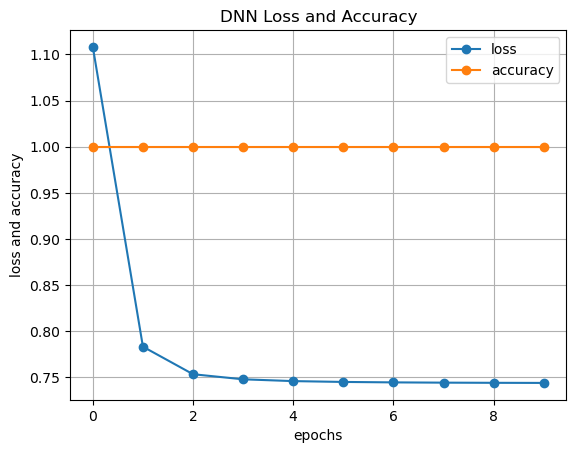

In [23]:
# 손실, 정확도 그래프 출력
plt.plot(range(epochs), loss_lst, marker='o', linestyle='-', label='loss')
plt.plot(range(epochs), acc_lst, marker='o', linestyle='-', label='accuracy')
plt.grid(True)
plt.title('DNN Loss and Accuracy')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(('loss', 'accuracy'))
plt.show()

### CNN 모델 학습
- GPU를 이용한 가속
    > - GPU를 사용하기 위해 사용 여부 확인 후 사용.

- loss Function (손실함수) : Cross Entropy Loss 사용
    > - 소프트맥스 분류기를 사용하기 때문에 Cross Entropy Loss 손실함수를 사용하여 손쉽게 분류가 가능하다.

- Optimizer : Adam 사용
    > - Adam이 현재 성능이 가장 좋은 Optimizer이기에 사용.

- 미니 배치 학습
     - 미니 배치 학습을 위해 `DataLoader`에서 Batch Size를 1000으로 설정함.
     - Batch Size가 너무 작으면 전체 데이터를 대표하지 못하기 때문에 적절한 Size 설정이 필요하다.
     - 이러한 점으로 고려해봤을 때 데이터의 Input 주기를 고려해서 설정하는 것이 중요해 보인다. (1초에 N개의 데이터 쌍이 들어왔는가?)

- Epoch : 10
    > - 학습을 시키는 도중 Epoch가 2~3회 정도 마쳤을 때 이미 Accuarcy가 1.0에 도달하였기 때문에 더 이상 Epoch 수를 증가 시키는 것은 무의미하다고 판단함.
    > - Epoch가 적게 동작했음에도 불구하고 Accuarch가 1.0에 도달했다는 것은 Overfitting이 발생하였다는 것으로 보임.
    

In [ ]:
# GPU 사용 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 모델 초기화
model = QPSKDemodulationCNN().to(device)
cel = torch.nn.CrossEntropyLoss()  # 손실 함수
# Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 10
loss_lst = []  # 손실 저장
acc_lst = []  # 정확도 저장

for epoch in range(epochs):
    model.train()
    l_sum = 0
    for batch_idx, (x,y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        optimizer.zero_grad()
        loss = cel(y_pred, y)
        loss.backward()
        optimizer.step()
        l_sum += loss.item()
    loss = l_sum/len(train_loader)
    loss_lst.append(loss)
    model.eval()
    correct = 0
    for batch_idx, (x,y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        predicted = torch.argmax(y_pred, dim=1)
        correct += torch.sum(predicted == y)
    accuracy = correct / len(test_data)
    # 정확도를 CPU로 이동하여 저장 -> 그래프 그릴 때 에러 방지
    acc_lst.append(accuracy.cpu().numpy())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 1.0547, Accuracy: 1.0000
Epoch 2/10, Loss: 0.7619, Accuracy: 1.0000
Epoch 3/10, Loss: 0.7478, Accuracy: 1.0000
Epoch 4/10, Loss: 0.7455, Accuracy: 1.0000
Epoch 5/10, Loss: 0.7446, Accuracy: 1.0000
Epoch 6/10, Loss: 0.7442, Accuracy: 1.0000
Epoch 7/10, Loss: 0.7440, Accuracy: 1.0000
Epoch 8/10, Loss: 0.7439, Accuracy: 1.0000
Epoch 9/10, Loss: 0.7438, Accuracy: 1.0000
Epoch 10/10, Loss: 0.7438, Accuracy: 1.0000


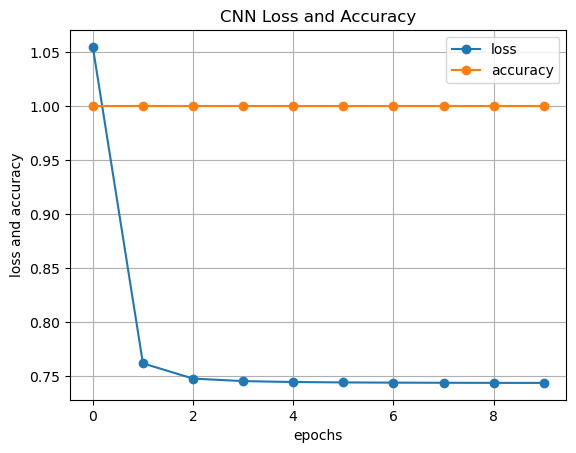

In [25]:
# 손실, 정확도 그래프 출력
plt.plot(range(epochs), loss_lst, marker='o', linestyle='-', label='loss')
plt.plot(range(epochs), acc_lst, marker='o', linestyle='-', label='accuracy')
plt.grid(True)
plt.title('CNN Loss and Accuracy')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(('loss', 'accuracy'))
plt.show()

#### BER 계산
1. `calculate_ber` 함수
    - 원본 비트 스트림 (`te_bits.csv`)와 예측 비트 스트림의 BER을 계산하는 함수
2.  `plot_ber` 함수
    - 계산한 BER 값을 `plt.semilogy`을 이용하여 시각화하는 함수.
3. `evaluate_and_plot_ber` 함수
    - SNR 값 범위 (0~10)을 순회하며 딥러닝 복호화 및 BER을 계산하는 함수.

In [29]:
# BER 계산 함수
def calculate_ber(original_bits, predicted_bits):
    original_bits = np.array(original_bits)
    predicted_bits = np.array(predicted_bits)

    # Count the number of bit errors
    bit_errors = np.sum(original_bits != predicted_bits)

    # Calculate BER
    ber = bit_errors / len(original_bits)
    return ber

# BER 그래프 작성 함수
def plot_ber(snr_values, ber_values):
    plt.figure(figsize=(8, 6))
    plt.semilogy(snr_values, ber_values, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.title("BER vs SNR (Log Scale)", fontsize=14)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("Bit Error Rate (BER)", fontsize=12)
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.show()

# SNR에 따른 BER 계산 및 그래프 작성
def evaluate_and_plot_ber(model, X_test, y_test, snr_range):
    ber_values = []
    for snr_db in snr_range:
        # 복소수로 변환
        X_test_complex = X_test[:, 0] + 1j*X_test[:, 1]
        # awgn 추가
        X_test_noise = awgn_(X_test_complex, snr_db)
        # 실수부와 허수부 분리
        X_test_real_parts = X_test_noise.real
        X_test_imag_parts = X_test_noise.imag
        # 텐서로 변환
        X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)
        
        model.eval()
        with torch.no_grad():
            x = X_test_noise_tensor.to(device)
            y_pred = model(x)
            predicted_dec = torch.argmax(y_pred, dim=1)
        

        # 예측 값 정수 -> 비트 변환
        predicted_bits = []
        for i in range(len(predicted_dec)):
            if predicted_dec[i] == 0:
                predicted_bits.append(0)
                predicted_bits.append(0)
            elif predicted_dec[i] == 1:
                predicted_bits.append(0)
                predicted_bits.append(1)
            elif predicted_dec[i] == 2:
                predicted_bits.append(1)
                predicted_bits.append(0)
            else:
                predicted_bits.append(1)
                predicted_bits.append(1)
        # BER 계산
        ber = calculate_ber(y_test, predicted_bits)
        ber_values.append(ber)

    # BER 그래프 작성
    plot_ber(snr_range, ber_values)



C:\Users\Kyounghwan-Kim\AppData\Local\Temp\ipykernel_31944\722683689.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)


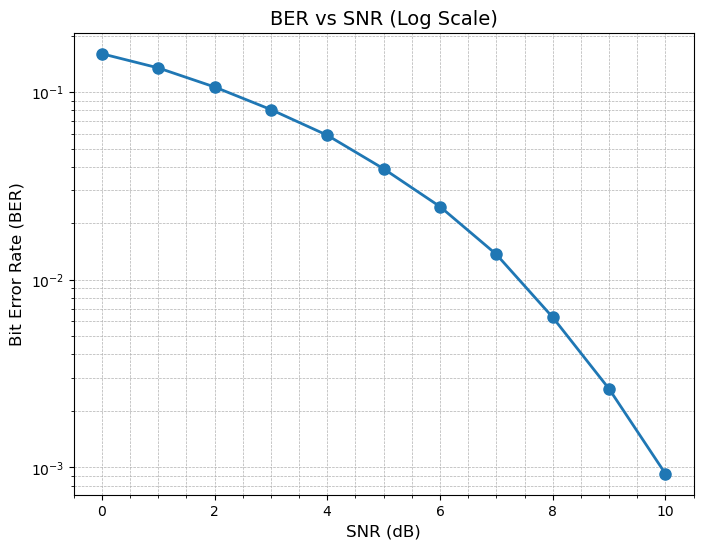

In [30]:
# SNR 범위 설정
snr_range = range(0, 11)  # 0 dB부터 10 dB까지

# BER 평가 및 그래프 작성
y_test = pd.read_csv('./data/te_bits.csv', header=None)
flatten_y_test = y_test.values.flatten()
evaluate_and_plot_ber(model, test_x_tensor, flatten_y_test, snr_range)

예상과 같이 SNR이 증가할 수록 BER이 감소하는 그래프를 확인할 수 있다.